<h1 style="font-size: 40px; margin-bottom: 0px;">12.2 Clustering and Differential Expression Analysis</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 950px;"></hr>

Today, we'll continue to play around with our RNA-seq counts by looking at two other ways we can cluster our data, and then we'll perform differential expression analysis to obtain a .csv file that we can then load into Python. As we're performing the differential expression analysis, we'll break it up into smaller steps to review what Dr. Ingolia taught in lecture to see what's going on under the hood.

<strong>Learning objectives:</strong>

<ul>
    <li>Play with color palettes</li>
    <li>Explore clustering methods</li>
    <li>Review differential expression analysis</li>
    <li>Perform differential expression analysis</li>
</ul>

<h1>Load in packages</h1>

Like our previous lesson, we'll first load in the packages that we'll need for today's analysis, and then we'll briefly review some of the initial steps of DESeq2 that we did previously to set up for our principal component analysis. We'll have the same set up here in this notebook in order to perform some other clustering methods.

Two new packages that we'll make use of today are <code>pheatmap</code> to generate heatmaps and <code>viridis</code> to get a specific type of color palette. And we'll still be making use of <code>DESeq2</code>, <code>ggplot2</code>, and <code>hexbin</code>. 

In [1]:
library(DESeq2)
library(ggplot2)
BiocManager::install("hexbin")
library(pheatmap)
library(viridis)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb



<h1>Play with color palettes in R</h1>

So to start off with today, we'll play around with some color palettes. Specifically, we can take a look at the viridis colormap, which you might recognize as the default colormap for matplotlib in Python when we didn't specify a colormap for our imported image files. We'll then make use of these color palettes that we create for visualizing our clustering results.

<a href="https://cran.r-project.org/web/packages/viridis/vignettes/intro-to-viridis.html" rel="noopener noreferrer" target="_blank"><u>A helpful vignette on the viridis color scale can be found here</u></a> (Rudis, Ross and Garnier). It describes the different color scales contained within the viridis package, and also demonstrates how the color scales, particularly viridis (designed by Eric Firing), is useful for data visualization that is readable by those with different types of color-blindness, allowing your data visualizations to be more accessible. The vignette also contains a pretty visualization that we can use to test out our own color palettes as well.

<h2>Viridis color palette</h2>

We can use the <code>viridis()</code> function to quickly generate a list of hex codes corresponding to the viridis color palette. We can provide it with the number of hex codes we want it to generate, and it will generate a list spanning the viridis color map.

```
viridis(255)
```

This example will generate a list containing 255 hex codes that span the viridis color map.

In [3]:
viridis(10)

[1] "#440154FF" "#482878FF" "#3E4A89FF" "#31688EFF" "#26828EFF" "#1F9E89FF"
 [7] "#35B779FF" "#6DCD59FF" "#B4DE2CFF" "#FDE725FF"

Now let's see how the colors work in a visualization, pulling the code from the vignette with some slight modifications:

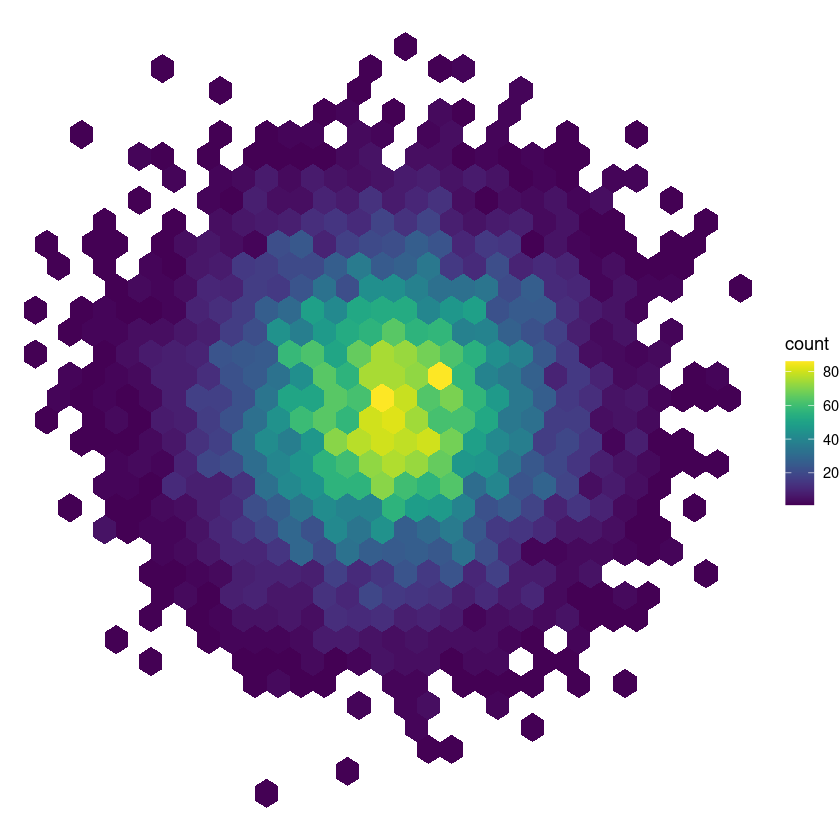

In [4]:
ggplot(data.frame(x = rnorm(10000), y = rnorm(10000)), aes(x = x, y = y)) +
    geom_hex() +
    theme_void() +
    coord_fixed() +
    scale_fill_gradientn(colors=viridis(255))

<h2>Setting up a color palette using <code>colorRampPalette()</code></h2>

Plenty of different color maps exist both for R and in Python, which can be used for data visualizations such as heatmaps. However, sometimes you might feel that existing color maps don't capture exactly how you want your data to be visualized stylistically. In that case, you can make use of the <code>colorRampPalette()</code> function to generate your own graded color palettes. <a href="https://www.rdocumentation.org/packages/dichromat/versions/1.1/topics/colorRampPalette" rel="noopener noreferrer" target="_blank"><u>Documentation for <code>colorRampPalette()</code> is here.</u></a>

So you can provide the function with a list of your colors (either names, hex codes, etc) that you want it to span, and it can generate a gradient of colors that span the ones you specify:

```
my.fav.col.map <- colorRampPalette(colors = c("aquamarine", "grey", "hotpink"))
```

<a href="https://www.nceas.ucsb.edu/sites/default/files/2020-04/colorPaletteCheatsheet.pdf" rel="noopener noreferrer" target="_blank"><u>A helpful cheatsheet for colors and other color palettes can be found here by Melanie Frazier.</u></a>


You can then specify how many hex codes to generate by slightly modifying your line of code:

```
my.fav.col.map <- colorRampPalette(colors = c("aquamarine", "grey", "hotpink"))(255)
```

In this setup, you'll generate a list of 255 hex codes that span from aquamarine to grey to hot pink. 

Then, you can provide this color map to your functions for data visualizations, allowing you to create custom color maps based on the needs of your individual figures or the data/information that you are trying to convey.

In [5]:
my.fav.col.map <- colorRampPalette(colors = c("aquamarine", "grey", "hotpink"))

In [6]:
my.fav.col.map

function (n) 
{
    x <- ramp(seq.int(0, 1, length.out = n))
    if (ncol(x) == 4L) 
        rgb(x[, 1L], x[, 2L], x[, 3L], x[, 4L], maxColorValue = 255)
    else rgb(x[, 1L], x[, 2L], x[, 3L], maxColorValue = 255)
}
<bytecode: 0x5a6121274390>
<environment: 0x5a61212716e0>

In [7]:
my.fav.col.map <- colorRampPalette(colors = c("aquamarine", "grey", "hotpink"))(255)

In [ ]:
my.fav.col.map

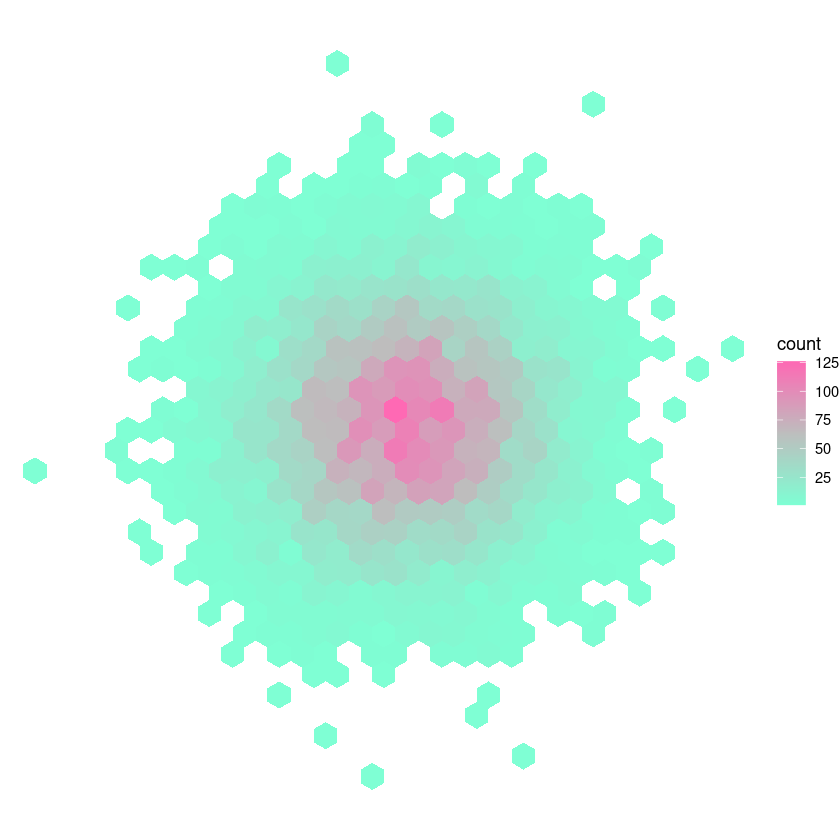

In [9]:
ggplot(data.frame(x = rnorm(10000), y = rnorm(10000)), aes(x = x, y = y)) +
    geom_hex() +
    theme_void() +
    coord_fixed() +
    scale_fill_gradientn(colors=my.fav.col.map)

<h1>Prepare your <code>DESeqDataSet</code></h1>

Since this is a new notebook, we'll need to bring in our counts matrix and conditions matrix again and use them to create a <code>DESeqDataSet</code> for us to use to do some more clustering. 

For convenience, I've just copied over the code from our previous lesson, so you don't need to retype it.

In [10]:
#Here we're importing our counts matrix.
counts <- read.csv('~/MCB201B_F2024/Week_12/1M_counts_matrix.csv',
                   stringsAsFactors=FALSE,
                   row.names=1
                   )

#Then we're importing our conditions matrix.
conditions <- read.csv('~/MCB201B_F2024/Week_10/quant/1M_conditions_matrix.csv',
                   stringsAsFactors=FALSE,
                   row.names=1
                   )

#Update our column headers to match
colnames(counts) <- rownames(conditions)

#Filter out non-expressed genes.
means <- apply(counts, 1, mean)
counts <- counts[which(means>0),]

#Create your DESeqDataSet
dds <- DESeqDataSetFromMatrix(countData = counts,
                              colData = conditions,
                              design = ~ condition
                             )

#Estimate size factors - this is actually the start of differential expression analysis
dds <- estimateSizeFactors(dds)

#Perform a regularized log transformation
#Like with PCA, this will be the values we use for additional clustering
#This part is not differential expression but more like QC
rld <- rlog(dds, blind=FALSE)

#Pull the rlog transformed values to sort them and get the top 500 variance genes
rld.values <- assay(rld)
rld.var.sort <- rld.values[order(rowVars(rld.values), decreasing = TRUE),]
top500.var.rld <- head(rld.var.sort, 500)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


<h1>Guided Exercise: Generate a distance matrix</h1>

Recall from Dr. Ingolia's clustering lecture that we can determine the similarities and dissimilarities of our samples by calculating their distances from one another, then using the resulting distance matrix to identify clusters of closely grouped samples. 

<h2>Calculate distances between replicates</h2>

To do this, we'll make use of the <code>dist()</code> function, which computes the distance matrix of a given data matrix. <a href="https://stat.ethz.ch/R-manual/R-devel/library/stats/html/dist.html" rel="noopener noreferrer" target="_blank"><u>Documentation for <code>dist()</code> is here.</u></a> If we dig into the documentation, we can see that it calculates the Euclidean distance between the rows, and it will output an object that can the be converted to a matrix via the function <code>as.matrix()</code>.

```
rep.distances <- dist(t(assay(rld)))
```

Breaking down this line of code, we have:

<code>rep.distances</code>

This is the variable to which we are saving our <code>dist</code> object.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>&lt;-</code>

This is our assignment operator.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>dist()</code>

This is the function to calculate the Euclidean distance between each row.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>t(assay(rld))</code>

Here, we provide it with the transposed rlog transformed counts matrix. Like with principal component analysis, the distances are determined between the rows, and since we are more interested in the similarities/differences between each of our replicates, we will provide it with a transposed matrix of our rlog transformed counts using the <code>t()</code> function.

In [11]:
rep.distances <- dist(t(assay(rld)))

Let's take a look at the output:

In [12]:
rep.distances

              1M_g1_control 1M_g1_tazko 1M_g2_control 1M_g2_tazko 1M_g3_control
1M_g1_tazko        38.27636                                                    
1M_g2_control      20.21569    37.77226                                        
1M_g2_tazko        38.60595    20.51329      37.85356                          
1M_g3_control      22.26251    33.00024      21.61275    33.26423              
1M_g3_tazko        37.88721    21.12466      37.74051    21.21857      33.37734
1M_g4_control      23.11935    31.91204      22.71186    32.26969      20.54372
1M_g4_tazko        38.38213    20.80561      37.82345    20.51008      33.40496
1M_g5_control      21.22523    33.87435      20.97770    34.14213      20.33380
1M_g5_tazko        38.37369    20.79428      37.85984    20.38689      33.47136
1M_g6_control      22.90867    32.58176      22.42504    32.74056      20.65394
1M_g6_tazko        38.66264    21.79842      37.80374    20.93915      33.05285
1M_g7_control      31.67129    28.58566 

<h2>Convert to a matrix</h2>

Now we can convert our <code>dist</code> object into a matrix that we can then use to generate a heatmap of our data based on the distance values for each point in our matrix. To do this, we'll use <a href="https://stat.ethz.ch/R-manual/R-devel/library/base/html/matrix.html" rel="noopener noreferrer" target="_blank"><u>a standard function called <code>as.matrix()</code></u></a>, which can convert our <code>dist</code> object into a 2D matrix. This function takes the object that you pass it and attempts to coerce it into a matrix.

```
rep.distances.matrix <- as.matrix(rep.distances)
```

In [13]:
rep.distances.matrix <- as.matrix(rep.distances)

Let's take a look at how our distance matrix looks:

In [15]:
rep.distances.matrix

,1M_g1_control,1M_g1_tazko,1M_g2_control,1M_g2_tazko,1M_g3_control,1M_g3_tazko,1M_g4_control,1M_g4_tazko,1M_g5_control,1M_g5_tazko,1M_g6_control,1M_g6_tazko,1M_g7_control,1M_g7_tazko,1M_g8_control,1M_g8_tazko
1M_g1_control,0.00000,38.27636,20.21569,38.60595,22.26251,37.88721,23.11935,38.38213,21.22523,38.37369,22.90867,38.66264,31.67129,37.93241,32.04445,39.02085
1M_g1_tazko,38.27636,0.00000,37.77226,20.51329,33.00024,21.12466,31.91204,20.80561,33.87435,20.79428,32.58176,21.79842,28.58566,22.42634,29.86410,22.04053
1M_g2_control,20.21569,37.77226,0.00000,37.85356,21.61275,37.74051,22.71186,37.82345,20.97770,37.85984,22.42504,37.80374,30.66216,37.14060,31.82302,38.15056
1M_g2_tazko,38.60595,20.51329,37.85356,0.00000,33.26423,21.21857,32.26969,20.51008,34.14213,20.38689,32.74056,20.93915,28.09279,21.74523,30.97513,21.49543
1M_g3_control,22.26251,33.00024,21.61275,33.26423,0.00000,33.37734,20.54372,33.40496,20.33380,33.47136,20.65394,33.05285,26.06223,33.02807,27.46323,33.54711
1M_g3_tazko,37.88721,21.12466,37.74051,21.21857,33.37734,0.00000,31.91335,20.52005,33.94043,20.72784,33.06590,22.81143,29.67376,22.34372,30.27434,23.00554
1M_g4_control,23.11935,31.91204,22.71186,32.26969,20.54372,31.91335,0.00000,32.01179,21.02063,32.08022,21.36267,32.22140,25.21897,31.69981,26.64315,32.59260
1M_g4_tazko,38.38213,20.80561,37.82345,20.51008,33.40496,20.52005,32.01179,0.00000,33.92032,20.37021,33.16243,22.33458,29.19046,22.20743,31.02074,22.51338
1M_g5_control,21.22523,33.87435,20.97770,34.14213,20.33380,33.94043,21.02063,33.92032,0.00000,34.03855,20.49965,34.10500,26.92574,33.61556,28.14764,34.49580
1M_g5_tazko,38.37369,20.79428,37.85984,20.38689,33.47136,20.72784,32.08022,20.37021,34.03855,0.00000,32.97982,22.20871,29.05308,22.04588,31.20912,22.05308


<h1>Plot a heatmap of sample distances</h1>

Now that we have a matrix of the Euclidean distances between our samples, we can then generate a heatmap of their distances while clustering our samples based on how close or far away they are from each other.

For this type of plotting, we'll make use of the pheatmap package. <a href="https://cran.r-project.org/web/packages/pheatmap/pheatmap.pdf" rel="noopener noreferrer" target="_blank"><u>Documentation for the pheatmap package is here.</u></a> Specifically, we'll make use of the <code>pheatmap()</code> function, which will allow us to cluster our data based on their Euclidean distances that we calculated using the <code>dist()</code> function.

In [21]:
pheatmap(rep.distances.matrix,
         clustering_distance_rows=rep.distances,
         clustering_distance_cols=rep.distances,
         col=viridis(255),
         main='Distance matrix heatmap',
         filename='distance-matrix.pdf'
         )

You should see a heatmap colored with the color map that you specified, where the diagonal corresponds to a zero because it is the distance between the sample itself. 

We can identify groupings of our data based on the dendogram built up based on the distances (recall from Dr. Ingolia's lecture), and we can also see them as the larger squares that we see.

<h2>Save distance matrix heatmap</h2>

We can make a quick adjustment to our code to then output the plot directly to a file rather than into the notebook by passing an additional argument to the <code>pheatmap()</code> function. This argument is <code>filename='name-of-file.ext'</code>.

<h1>Perform hierarchical clustering</h1>

Another way of determining the similarities and dissimilarities of our samples is to perform hierarchical clustering based on our top 500 genes with the highest variance.

We'll continue to make use of the <code>pheatmap()</code> function, but we'll provide it with a different set of arguments.

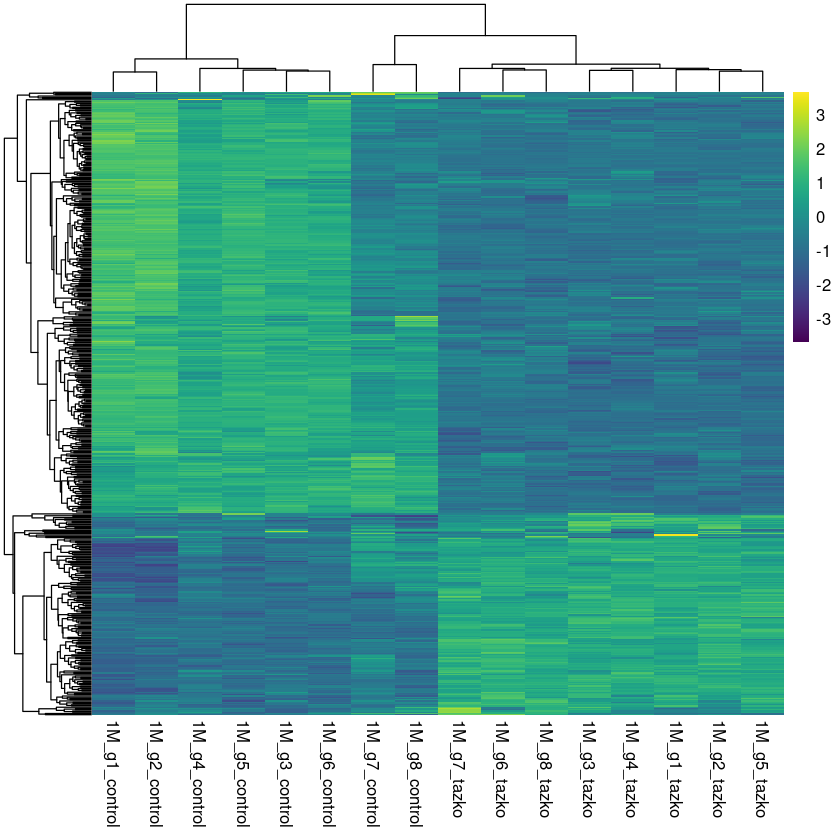

In [26]:
pheatmap(top500.var.rld,
         color = viridis(255),
         scale= "row",
         border_color=NA,
         show_rownames=FALSE
         )

You should see a heatmap that looks a little different than the heatmap that we generated earlier. You can see how our data is grouped together, but now we can also see clusters of our genes, where we have clusters of genes that are overexpressed in our TAZ KO samples and groups of genes that exhibit reduced expression in our KO samples. 

You might notice that the legend for this figure looks different than that of our distance matrix heatmap. This is due to the fact that we supplied the argument <code>scale="row"</code>. This argument centers the mean of the data around 0 and scales the standard deviation to be 1, which makes differences between the rows (our genes) more apparent. You'll want to be careful interpretting the result because a negative scaled value does not necessarily mean that the gene exhibits reduced expression. Rather, it means that it is however many standard deviations below the mean expression level for the dataset you're looking at. Try commenting out the <code>scale="row"</code> argument to see how the heatmap changes.

And again, if we want to output the figure into a file, we can make use of the same argument we used earlier. 

<h1>Differential Expression Analysis</h1>

Here, we'll return to our <code>DESeqDataSet</code> to finish up our differential expression analysis. Recall from Dr. Ingolia's lecture that we've already performed some of the intial steps for differential expression analysis, where we estimated the size factors in order to account for differences in sequencing depth.

<h2>Estimate Dispersions</h2>

The next step is to then estimate the spread of our measurements, otherwise referred to as the dispersion. DESeq2 calculates the estimated dispersion (&#593;) as a function of the mean (&micro;) and variance. In other words, the estimated dispersion is the expected spread of the data for a given mean based on your data. This allows DESeq2 to identify what is likely to be true variation in the data resulting from biological or technical effects by shrinking the dispersion  of each gene towards the calculated estimated value for that specific mean. This can be thought of as modeling what the noise is for our experiment in order to distinguish biological and technical differences in our samples from what are just noise in our measurements.

We'll do this by making use of the <code>estimateDispersions()</code> function, which is part of the DESeq2 package.

```
dds <- estimateDispersions(dds)
```

Like with our other intermediate calculations, we place the output into our <code>DESeqDataSet</code>.

In [27]:
dds <- estimateDispersions(dds)

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



Then we can visualize the dispersion estimate using the <code>plotDispEsts()</code> function.

```
plotDispEsts(dds)
```

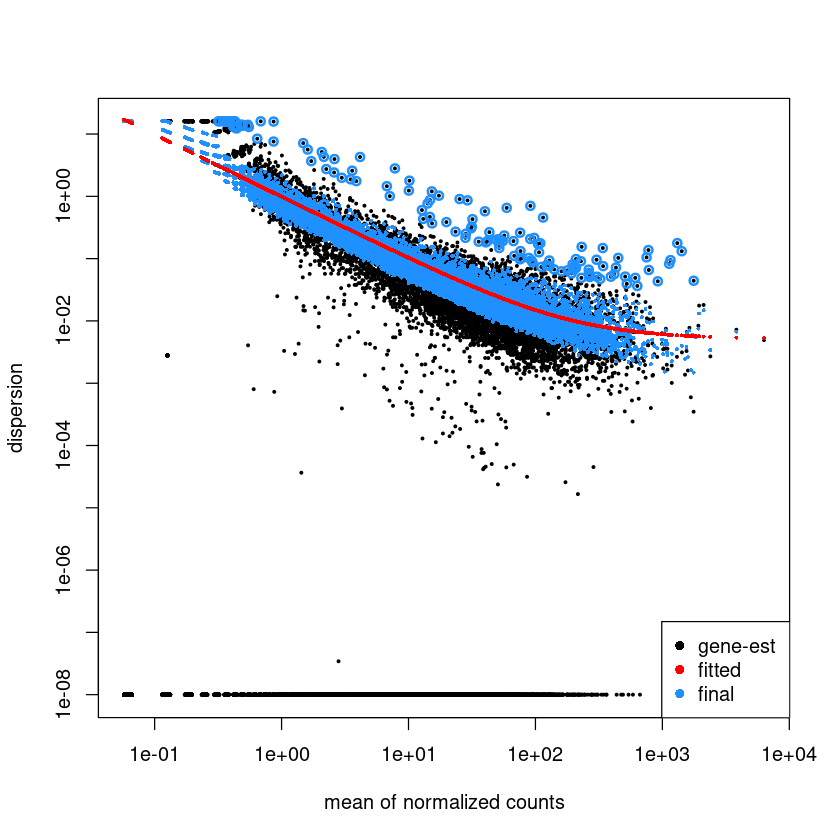

In [28]:
plotDispEsts(dds)

In the plot, each dot corresponds to a single gene plotted with its mean on the X-axis and its calculated dispersion on the Y-axis. The red line is the estimated dispersion based on your whole dataset. A "good" dispersion plot should have genes following the estimated dispersion. The blue indicates the final dispersion after shrinkage, essentially removing what variation may be just due to noise in the measurements. The dots with the genes showing potential biological or technical variation greater than the expected noise marked with a blue outline.

What you would normally expect to see is a fitted line that increases in dispersion as the mean decreases (inversely correlated to mean). This is due to the fact that noise has a greater impact (accounts for more of the variation) when the mean is smaller.

<h2>Hypothesis testing: negative binomial Wald test to determine significance</h2>

Finally, we'll use the Wald test to detect differentially expressed genes and determine if they are significant. DESeq2 models expression based on a negative binomial distribution, and recall from Dr. Ingolia's lecture that the negative binomial distribution can be thought of like a Poisson distribution but with extra variance as a second parameter. 

For hypothesis testing, DESeq2 sets the null hypothesis for each gene as having no difference between sample groups, so no log fold change difference (equal to 0). To test this hypothesis, DESeq2 makes use of the Wald test to compare the sample groups.

To run a Wald test on our samples, we can make use of the <code>nbinomWaldTest()</code> function.

```
dds <- nbinomWaldTest(dds)
```

In [29]:
dds <- nbinomWaldTest(dds)

Then we can pull out the results out of our <code>DESeqDataSet</code> using the <code>results()</code> function, and then assigning that to a new variable.

```
res <- results(dds)
```

In [30]:
res <- results(dds)

Let's take a look at how our results table looks like:

In [31]:
res

log2 fold change (MLE): condition taz ko vs control 
Wald test p-value: condition taz ko vs control 
DataFrame with 18096 rows and 6 columns
          baseMean log2FoldChange     lfcSE      stat    pvalue      padj
         <numeric>      <numeric> <numeric> <numeric> <numeric> <numeric>
A1BG     1.0851709       1.773600  0.984973  1.800658 0.0717568  0.199049
A1BG-AS1 1.7808830      -0.735528  0.671003 -1.096162 0.2730079  0.489257
A2M      0.0663336      -0.379204  3.060383 -0.123907 0.9013886        NA
A2M-AS1  0.3041440      -1.761840  1.816649 -0.969830 0.3321315        NA
A4GALT   9.9903380       0.445315  0.294571  1.511738 0.1306004  0.303393
...            ...            ...       ...       ...       ...       ...
ZYG11A      7.1248       0.324217  0.354786   0.91384 0.3608008  0.580910
ZYG11B     42.2914       0.214396  0.159847   1.34126 0.1798376  0.374248
ZYX       106.1961       0.195402  0.114614   1.70487 0.0882190  0.230383
ZZEF1      36.4215      -0.116984  0.169539  

<h2>Export results of differential expression analysis</h2>

Like with Python, we can export the dataframe containing our results, just with slightly different syntax.

```
write.csv(res, '1M_results.csv')
```

This will output a .csv file containing the results of our differential expression analysis.

In [32]:
write.csv(res, '1M_results.csv')

<h2>Export rlog transformed counts</h2>

While we're at it, let's also export our rlog transformed counts for use later on.

In [33]:
write.csv(rld.values, '1M_rlog_counts.csv')

<h2>Generate an MA Plot</h2>

Recall that you previously generated an MA plot for your group's replicate using the ratio between your TAZ KO and control counts and their average counts.

Now with our differential expression analysis results, we can generate an MA plot from our class dataset. To do this, we'll make use of DESeq2's <code>plotMA()</code> function.

```
plotMA(res)
```

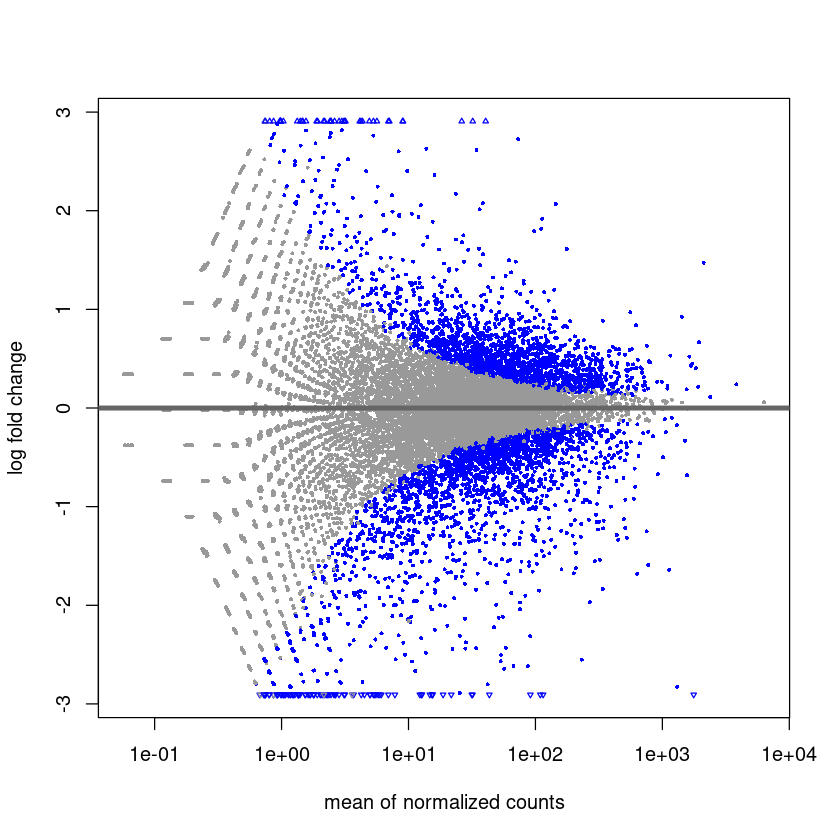

In [34]:
plotMA(res)

By default, <code>plotMA()</code> highlights genes whose p-adjusted (p-value corrected for multiple hypothesis testing) is less than 0.1.

We can supply additional arguments to the function to slightly adjust our plot:

```
plotMA(res,
       alpha=0.05,
       xlab='Mean of normalized counts', 
       ylab='Log fold change', 
       main='MA plot',
       ylim=c(-5,5)
       )
```

In [36]:
pdf('MA_plot_log_fold_change.pdf')
plotMA(res,
       alpha=0.05,
       xlab='Mean of normalized counts', 
       ylab='Log fold change', 
       main='MA plot',
       ylim=c(-5,5)
       )
dev.off()

pdf 
  2

<h2>Obtain shrunken log fold change values</h2>

As you can see, much like with our MA plot for our single replicate, genes that have a lower mean also exhibit a greater log fold change, giving the MA plot its characteristic arrowhead shape. This is due to the fact that noise in the measurements will lead to larger dispersion and a greater log fold change.

We can correct for this by calculating the shrunken log fold change. This allows us to better visualize genes whose differential expression is likely due to true biological or technical variance rather than noise. 

First, let's pull out the comparison groups from our <code>DESeqDataSet</code>:

```
resultsNames(dds)
```

In [38]:
resultsNames(dds)

[1] "Intercept"                   "condition_taz_ko_vs_control"

Then, we can call up the <code>lfcShrink()</code> function to calculate our shrunken log fold change:

```
resLFC <- lfcShrink(dds, 
                    coef="condition_tazko_vs_ctrl",
                    type="apeglm"
                    )
```

In [41]:
resLFC <- lfcShrink(dds, 
                    coef="condition_taz_ko_vs_control",
                    type="apeglm"
                    )

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



Now let's take a look at the results and export them for use later:

In [42]:
resLFC

log2 fold change (MAP): condition taz ko vs control 
Wald test p-value: condition taz ko vs control 
DataFrame with 18096 rows and 5 columns
          baseMean log2FoldChange     lfcSE    pvalue      padj
         <numeric>      <numeric> <numeric> <numeric> <numeric>
A1BG     1.0851709      0.2113194  0.392672 0.0717568  0.199049
A1BG-AS1 1.7808830     -0.1426680  0.317841 0.2730079  0.489257
A2M      0.0663336     -0.0171694  0.310137 0.9013886        NA
A2M-AS1  0.3041440     -0.0696166  0.319293 0.3321315        NA
A4GALT   9.9903380      0.2696083  0.258235 0.1306004  0.303393
...            ...            ...       ...       ...       ...
ZYG11A      7.1248      0.1496646  0.255240 0.3608008  0.580910
ZYG11B     42.2914      0.1744546  0.147949 0.1798376  0.374248
ZYX       106.1961      0.1748821  0.109995 0.0882190  0.230383
ZZEF1      36.4215     -0.0907978  0.150872 0.4901880  0.692329
ZZZ3       81.2886     -0.2800771  0.158350 0.0413418  0.133418

In [43]:
write.csv(resLFC, '1M_result_shrinkLFC.csv')

<h2>Plot MA plot for shrunken log fold change</h2>

Now let's take a look at how our MA plot looks like when we take into account that lower means are expected to have higher log fold change:

In [45]:
pdf('MA_plot_shrink_log_fold_change.pdf')
plotMA(resLFC,
       alpha=0.05,
       xlab='Mean of normalized counts', 
       ylab='Log fold change', 
       main='MA plot',
       ylim=c(-5,5)
       )
dev.off()

pdf 
  2